# 합성곱 신경망의 구성요소
### 합성곱
- 커널 : 입력에 곱하는 가중치
- 필터 : 뉴런 개수
- 입력이 2차원배열이면 필터도 2차원
- 합성곱 계산을 통해 얻은 출력을 특성맵(Feature map)이라고 한다.


### 패딩(Padding) 
- 입력 배열의 주위를 가상의 원소로 채우는 것
- 세임패딩(Same padding) : 입력 배열의 주위를 0으로 패딩

**패딩의 필요성**

- 픽셀이 합성곱에 참여하는 비율차이를 줄이기 위해


- 스트라이드(Stride) : 합성곱 연산의 건너뛰는 크기

In [1]:
from tensorflow import keras
keras.layers.Conv2D(10, kernel_size=(3,3), activation='relu')

In [2]:
keras.layers.Conv2D(10, kernel_size=(3,3), activation='relu', padding='same') # 세임 패딩 설정

In [3]:
keras.layers.Conv2D(10, kernel_size=(3,3), activation='relu', padding='same', strides=1) # 스트라이드 설정 , default=1

### 풀링(Pooling)
- 특성 맵의 가로세로 크기를 줄이는 것, 차원의 개수는 줄이지않음

EX) (2,2,3) 크기에 풀링적용하면 (1,1,3)

- 최대풀링 : 가장 큰값을 골라 출력, keras.layers.MaxPooling2D(2)
- 평균풀링 : 평균 값을 계산하여 출력 keras.layers.AveragePooling2D(2)

**풀링에서는 겹치지않고 이동한다**
- 풀링크기가 (2,2)이면 strides=2, (3,3)이면 strides=3

### 합성곱 신경망의 전체구조
패딩적용한 (4,4) --> 합성곱 층(세임패딩), (4,4,3)특성맵 --> 풀링층,(2,2)최대풀링,(2,2,3)특성맵,1차원으로 펼치기 --> 밀집층 --> 예측

# 합성곱 신경망을 사용한 이미지 분류
- 합성곱 신경망은 2차원이미지를 그대로 사용하기 때문에 입력이미지를 일렬로 펼치지않는다.

- Conv2D층을 사용하기 위해 마지막에 채널 차원을 추가해야한다.

In [4]:
from tensorflow import keras
from sklearn.model_selection import train_test_split
(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()
train_scaled = train_input.reshape(-1 ,28,28,1)/255.0 # 데이터 스케일을 0~255사이를 0~1사이로 변환해야한다
train_scaled, val_scaled, train_target, val_target = train_test_split(
    train_scaled, train_target, test_size=0.2, random_state=42)

In [5]:
print(train_scaled.shape)
print(train_target.shape)
print(val_scaled.shape)
print(val_target.shape)

(48000, 28, 28, 1)
(48000,)
(12000, 28, 28, 1)
(12000,)


### 합성곱 신경망 만들기

In [6]:
## 합성곱 층
## 32개의 필터, 커널(3,3)
model = keras.Sequential()
model.add(keras.layers.Conv2D(32, kernel_size=3, activation='relu', padding='same', input_shape=(28,28,1)))

In [7]:
## 풀링층
## 풀링 (2,2) 적용했으므로 이미지 (28,28)은 절반인 (14,14)
## 합성곱 층에서 32개의 필터를 사용했기 때문에 특성 맵의 깊이는 32 이므로 (14,14,32)
model.add(keras.layers.MaxPooling2D(2))

In [8]:
## 두번째 합성곱-풀링층
model.add(keras.layers.Conv2D(64, kernel_size=3, activation='relu', padding='same')) # 필터가 64개이므로 (14,14,64)
model.add(keras.layers.MaxPooling2D(2)) # (14,14,32) --> (7,7,64)

In [9]:
## 3차원 특성맵은 일렬로 펼친다.
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dropout(0.4)) # 과대적합 막기위함
model.add(keras.layers.Dense(10,activation='softmax')) # MNIST 데이터 셋은 클래스 10개를 분류하는 다중 분류 문제이므로 'softmax'

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               313700    
_________________________________________________________________
dropout (Dropout)            (None, 100)               0

In [11]:
# 층의 구성을 그림으로 표현
keras.utils.plot_model(model)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [12]:
## 입력과 출력의 크기 표시까지, to_file을 이용한 이미지를 파일로 저장, dpi로 해상도 지정
keras.utils.plot_model(model, show_shapes=True, to_file='cnn-architecture.png', dpi=100)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


### 모델 컴파일과 훈련

In [13]:
import tensorflow as tf
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-cnn-model.h5')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)
history = model.fit(train_scaled, train_target, epochs=20,
                    validation_data=(val_scaled, val_target), 
                    callbacks=[checkpoint_cb, early_stopping_cb])

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 33s 688us/sample - loss: 0.5253 - acc: 0.8116 - val_loss: 0.3165 - val_acc: 0.8827
Epoch 2/20
48000/48000 [==============================] - 34s 711us/sample - loss: 0.3468 - acc: 0.8754 - val_loss: 0.2736 - val_acc: 0.8999
Epoch 3/20
48000/48000 [==============================] - 34s 702us/sample - loss: 0.2948 - acc: 0.8931 - val_loss: 0.2572 - val_acc: 0.9048
Epoch 4/20
48000/48000 [==============================] - 37s 778us/sample - loss: 0.2650 - acc: 0.9035 - val_loss: 0.2414 - val_acc: 0.9124
Epoch 5/20
48000/48000 [==============================] - 36s 760us/sample - loss: 0.2401 - acc: 0.9124 - val_loss: 0.2209 - val_acc: 0.9172
Epoch 6/20
48000/48000 [==============================] - 36s 746us/sample - loss: 0.2235 - acc: 0.9177 - val_loss: 0.2303 - val_acc: 0.9161
Epoch 7/20
48000/48000 [==============================] - 36s 760us/sample - loss: 0.2050 - acc: 0.9234 

Duplicate key in file '/Users/yonghyunpark/.matplotlib/matplotlibrc', line 2 ('backend: TkAgg')


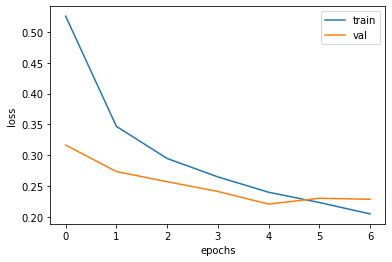

In [14]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()

In [15]:
model.evaluate(val_scaled, val_target)

12000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.22091393454869587, 0.91725]

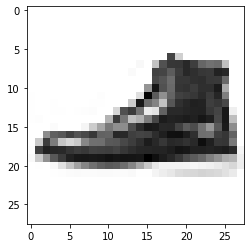

In [16]:
## predict()를 사용하여 훈련된 모델을 사용하여 새로운 데이터에 대해 예측
plt.imshow(val_scaled[19].reshape(28,28), cmap='gray_r') # matplotlib에서는 차원은없다.
plt.show()

In [17]:
preds = model.predict(val_scaled[19:20])
print(preds)

[[1.3543287e-08 5.7253379e-11 4.2679113e-10 5.3995076e-11 9.3087812e-12
  2.0444908e-07 2.5589106e-09 1.9136148e-02 1.4848844e-09 9.8086369e-01]]


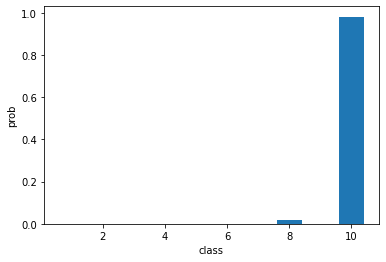

In [18]:
plt.bar(range(1,11), preds[0])
plt.xlabel('class')
plt.ylabel('prob')
plt.show()

In [19]:
classes = ['티셔츠','바지','스웨터','드레스','코트','샌들','셔츠','스니커즈','가방','앵클부츠']

In [20]:
import numpy as np
print(classes[np.argmax(preds)])

앵클부츠


In [21]:
## 테스트 세트로 일반화 성능 확인
test_scaled = test_input.reshape(-1,28,28,1)/255.0
model.evaluate(test_scaled, test_target)

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.23924844552278518, 0.9117]

# 합성곱 신경망의 시각화
### 가중치 시각화
- 가중치는 입력 이미지의 2차원 영역에 적용되어 어떤 특징을 크게 두드러지게 표현한다

In [22]:
## 어떤 가중치를 학습했는지 확인하기 위해 체크포인트 파일 가져오기
from tensorflow import keras
model = keras.models.load_model('best-cnn-model.h5')

In [23]:
model.layers


In [24]:
## 첫 번째 합성곱 층의 가중치
conv = model.layers[0]
print(conv.weights[0].shape, conv.weights[1].shape)

(3, 3, 1, 32) (32,)


- weights[0] : 커널크기(3,3,1), 필터개수 32개
- weights[1] : 절편 32개

In [25]:
## weights 속성을 넘파이배열로 변환하고 배열의 평균과 표준편차 계산
conv_weights = conv.weights[0].numpy()
print(conv_weights.mean(), conv_weights.std())

-0.031830296 0.25514778


In [26]:
conv_weights = conv.weights[0].numpy()

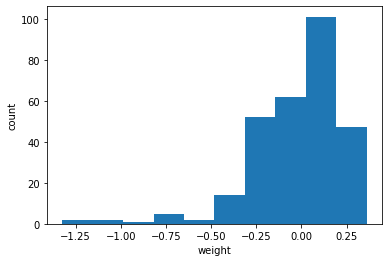

In [27]:
import matplotlib.pyplot as plt
plt.hist(conv_weights.reshape(-1,1))
plt.xlabel('weight')
plt.ylabel('count')
plt.show()

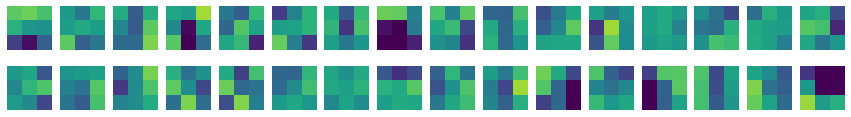

In [28]:
fig, axs = plt.subplots(2,16, figsize=(15,2))
for i in range(2):
    for j in range(16):
        axs[i,j].imshow(conv_weights[:,:,0,i*16+j], vmin=-0.5, vmax=0.5)
        axs[i,j].axis('off')
plt.show()

In [29]:
## 빈 합성곱 신경망
no_training_model = keras.Sequential()
no_training_model.add(keras.layers.Conv2D(32, kernel_size=3, activation='relu', padding='same', input_shape=(28,28,1)))

In [31]:
no_training_conv = no_training_model.layers[0]
print(no_training_conv.weights[0].shape)

(3, 3, 1, 32)


In [33]:
no_training_weights = no_training_conv.weights[0].numpy()
print(no_training_weights.mean(), no_training_weights.std())

0.0002720503 0.080248415


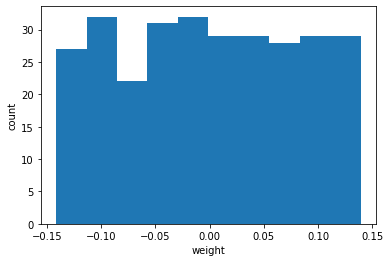

In [34]:
plt.hist(no_training_weights.reshape(-1,1))
plt.xlabel('weight')
plt.ylabel('count')
plt.show()

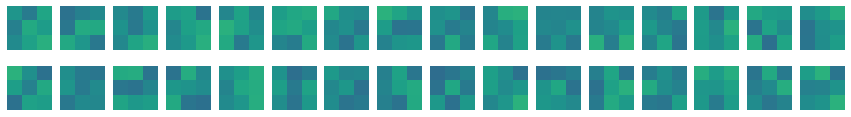

In [35]:
fig, axs = plt.subplots(2,16,figsize=(15,2))
for i in range(2):
    for j in range(16):
        axs[i,j].imshow(no_training_weights[:,:,0,i*16+j], vmin=-0.5, vmax=0.5)
        axs[i,j].axis('off')
        
plt.show()

### 함수형 API

In [44]:
dense1 = keras.layers.Dense(100, activation='sigmoid')
dense2 = keras.layers.Dense(10, activation='softmax')

In [45]:
print(model.input)

Tensor("input_1:0", shape=(None, 784), dtype=float32)


In [46]:
conv_acti = keras.Model(model.input, model.layers[0].output)

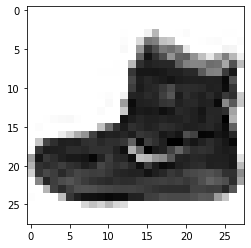

In [47]:
(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()
plt.imshow(train_input[0], cmap='gray_r')
plt.show()

Tensor("input_1:0", shape=(None, 784), dtype=float32)
